In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

#!conda install -c conda-forge pillow -y
!conda install -c conda-forge gdcm -y
!pip install pylibjpeg pylibjpeg-libjpeg

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm.notebook import tqdm
from concurrent.futures import ProcessPoolExecutor

import pydicom
from PIL import Image

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 22.9.0
  latest version: 22.11.1

Please update conda by running

    $ conda update -n base -c conda-forge conda



# All requested packages already installed.

Retrieving notices: ...working... done


# **Data Collection**

In [2]:
#Read in the test and train files, print first few rows of train file.
train = pd.read_csv("/kaggle/input/rsna-breast-cancer-detection/train.csv")
test = pd.read_csv("/kaggle/input/rsna-breast-cancer-detection/test.csv")
train.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True


# **Data definition**

In [3]:
#Summary of the train dataset:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54706 entries, 0 to 54705
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   site_id                  54706 non-null  int64  
 1   patient_id               54706 non-null  int64  
 2   image_id                 54706 non-null  int64  
 3   laterality               54706 non-null  object 
 4   view                     54706 non-null  object 
 5   age                      54669 non-null  float64
 6   cancer                   54706 non-null  int64  
 7   biopsy                   54706 non-null  int64  
 8   invasive                 54706 non-null  int64  
 9   BIRADS                   26286 non-null  float64
 10  implant                  54706 non-null  int64  
 11  density                  29470 non-null  object 
 12  machine_id               54706 non-null  int64  
 13  difficult_negative_case  54706 non-null  bool   
dtypes: bool(1), float64(2)

In [4]:
train.shape

(54706, 14)

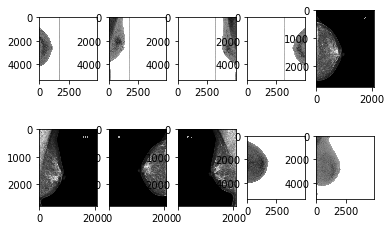

In [5]:
#Visualize the first 10 mammograms in the train dataset:
fig, axs = plt.subplots(2,5)

for i in range(10):
    patient_id = train['patient_id'][i]
    image_id = train['image_id'][i]
    path_img = '/kaggle/input/rsna-breast-cancer-detection/train_images/' + str(patient_id) + '/' + str(image_id) + '.dcm'
    im = pydicom.dcmread(path_img)
    arr = im.pixel_array
    axs[i//5][(i%5)].imshow(np.array(arr), interpolation='none', cmap='gray')

In [6]:
#We see that there are 2 kinds of images: the ones with a white background, and
#the ones with a black background. The two kinds of images correspond to two different 
#photometric interpretations (MONOCHROME1 or MONOCHROME2):
for i in range(10):
    patient_id = train['patient_id'][i]
    image_id = train['image_id'][i]
    path_img = '/kaggle/input/rsna-breast-cancer-detection/train_images/' + str(patient_id) + '/' + str(image_id) + '.dcm'
    im = pydicom.dcmread(path_img)
    print(im.PhotometricInterpretation, im.pixel_array.shape)
    
#We also see that the two types of images have different number of pixels. See the website 
#https://dicom.nema.org/medical/dicom/current/output/chtml/part03/sect_C.7.6.3.html#sect_C.7.6.3.1
#for more details about photometric interpretations.

MONOCHROME1 (5355, 4915)
MONOCHROME1 (5355, 4915)
MONOCHROME1 (5355, 4915)
MONOCHROME1 (5355, 4915)
MONOCHROME2 (2776, 2082)
MONOCHROME2 (2776, 2082)
MONOCHROME2 (2776, 2082)
MONOCHROME2 (2776, 2082)
MONOCHROME1 (5355, 4915)
MONOCHROME1 (5355, 4915)


In [7]:
#Converting the data type of a few columns from numerical to string or categorical.
train['site_id'] = train.site_id.astype('str')
train['patient_id'] = train.patient_id.astype('str')
train['image_id'] = train.image_id.astype('str')
train['cancer'] = train.cancer.astype('category')
train['biopsy'] = train.biopsy.astype('category')
train['invasive'] = train.invasive.astype('category')
train['BIRADS'] = train.BIRADS.astype('category')
train['implant'] = train.implant.astype('category')
train['machine_id'] = train.machine_id.astype('str')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54706 entries, 0 to 54705
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   site_id                  54706 non-null  object  
 1   patient_id               54706 non-null  object  
 2   image_id                 54706 non-null  object  
 3   laterality               54706 non-null  object  
 4   view                     54706 non-null  object  
 5   age                      54669 non-null  float64 
 6   cancer                   54706 non-null  category
 7   biopsy                   54706 non-null  category
 8   invasive                 54706 non-null  category
 9   BIRADS                   26286 non-null  category
 10  implant                  54706 non-null  category
 11  density                  29470 non-null  object  
 12  machine_id               54706 non-null  object  
 13  difficult_negative_case  54706 non-null  bool    
dtypes: boo

In [8]:
#Summary statistics for all the columns except 'age'.
train[['site_id','patient_id','image_id','laterality','view','cancer',
      'biopsy','invasive','BIRADS','implant','density','machine_id',
      'difficult_negative_case']].describe()

,site_id,patient_id,image_id,laterality,view,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
count,54706,54706,54706,54706,54706,54706,54706,54706,26286.0,54706,29470,54706,54706
unique,2,11913,54706,2,6,2,2,2,3.0,2,4,10,2
top,1,52868,462822612,R,MLO,0,0,0,1.0,0,B,49,False
freq,29519,14,1,27439,27903,53548,51737,53888,15772.0,53229,12651,23529,47001


In [9]:
#Summary statistics for 'age'.
train['age'].describe()

count    54669.000000
mean        58.543928
std         10.050884
min         26.000000
25%         51.000000
50%         59.000000
75%         66.000000
max         89.000000
Name: age, dtype: float64

In [10]:
#According to the Internet,the 'view' column should only have 2 values: 'CC'
#for the cranio-caudal view, and 'MLO' for the mediolateral oblique view.
#But it has 6 unique values, due to mispelling and mistakes.

print(train['view'].unique())

['CC' 'MLO' 'ML' 'LM' 'AT' 'LMO']


In [11]:
#We'll fix the mispellings/mistakes above later.

# **Data cleaning and organization**

In [12]:
#Count the number of missing values in each column and sort the columns by missing percentage.
missing = pd.concat([train.isnull().sum(), 100 * train.isnull().mean()], axis=1)
missing.columns=['count', '%']
missing.sort_values(by='%', ascending=False)

,count,%
BIRADS,28420,51.950426
density,25236,46.130223
age,37,0.067634
site_id,0,0.000000
patient_id,0,0.000000
image_id,0,0.000000
laterality,0,0.000000
view,0,0.000000
cancer,0,0.000000
biopsy,0,0.000000


In [41]:
#We see that half the rows have missing BIRADS or density data, and a small number of rows have missing age data.
#Because we have so much data available, we can simply drop the rows with missing data.
train_cleaned = train.copy().dropna().reset_index(drop=True)
print(train_cleaned.shape)
print(train_cleaned.isnull().sum())

(23647, 14)
site_id                    0
patient_id                 0
image_id                   0
laterality                 0
view                       0
age                        0
cancer                     0
biopsy                     0
invasive                   0
BIRADS                     0
implant                    0
density                    0
machine_id                 0
difficult_negative_case    0
dtype: int64


In [42]:
#Drop rows where 'view' column has value 'AT'.
#Also, where 'view' takes value 'LM' or 'ML' or 'LMO', reassign those values to 'MLO'.
train_cleaned = train_cleaned[train_cleaned['view'] != 'AT']
train_cleaned.loc[train_cleaned['view'].isin(['LM','ML','LMO']),'view'] = 'MLO'
train_cleaned.shape

(23634, 14)

In [43]:
#Summary statistics for the cleaned train set, 
#for all columns except 'age'
train_cleaned[['site_id','patient_id','image_id','laterality','view','cancer',
      'biopsy','invasive','BIRADS','implant','density','machine_id',
      'difficult_negative_case']].describe()

,site_id,patient_id,image_id,laterality,view,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
count,23634,23634,23634,23634,23634,23634,23634,23634,23634.0,23634,23634,23634,23634
unique,1,5801,23634,2,2,2,2,2,3.0,2,4,7,2
top,1,52868,1967300488,R,MLO,0,0,0,1.0,0,B,49,False
freq,23634,14,1,11873,12141,22972,21284,23186,15727.0,22407,10192,18489,18636


In [44]:
#Summary statistics for the 'age' column of the cleaned train set.
#Summary statistics for 'age'.
train_cleaned['age'].describe()

count    23634.000000
mean        57.235212
std         11.236745
min         26.000000
25%         48.000000
50%         57.000000
75%         65.000000
max         89.000000
Name: age, dtype: float64

In [46]:
#Turn the categorical columns into numerical data by using get_dummies.
train_cleaned_final = pd.get_dummies(train_cleaned, columns=['laterality', 'view',
                                      'cancer','biopsy', 'invasive', 'BIRADS',
                                      'implant','density','difficult_negative_case']).reset_index(drop=True)
print(train_cleaned_final.shape)
train_cleaned_final.head()

(23634, 26)


,site_id,patient_id,image_id,age,machine_id,laterality_L,laterality_R,view_CC,view_MLO,cancer_0,...,BIRADS_1.0,BIRADS_2.0,implant_0,implant_1,density_A,density_B,density_C,density_D,difficult_negative_case_False,difficult_negative_case_True
0,1,10038,1967300488,60.0,216,1,0,0,1,1,...,1,0,1,0,0,0,1,0,1,0
1,1,10038,2142944869,60.0,216,1,0,1,0,1,...,1,0,1,0,0,0,1,0,1,0
2,1,10038,850559196,60.0,216,0,1,0,1,1,...,1,0,1,0,0,0,1,0,1,0
3,1,10038,1350492010,60.0,216,0,1,1,0,1,...,1,0,1,0,0,0,1,0,1,0
4,1,10042,102733848,51.0,93,1,0,1,0,1,...,1,0,1,0,0,0,1,0,1,0


In [18]:
#Clean up the images, and making a list of them. The code in this cell is
#adapted from this Kaggle notebook:
#https://www.kaggle.com/code/rimzakhama/
#rsna-dcm-images-to-pngs-same-format-as-input
img_dict = {}

#for i in tqdm(range(train_cleaned_final.shape[0])):
def clean_image(i):

    patient_id = train_cleaned_final['patient_id'][i]
    image_id = train_cleaned_final['image_id'][i]
    path_img = '/kaggle/input/rsna-breast-cancer-detection/train_images/' + patient_id + '/' + image_id + '.dcm'
    im = pydicom.dcmread(path_img)
    arr = im.pixel_array
    
    #Rescaling pixel values to 255.
    scaled_arr = (arr / arr.max()) * 255.0
    
    #Converting all images to white background.
    if im.PhotometricInterpretation == "MONOCHROME2":
        scaled_arr = 255.0 - scaled_arr
        
    #Casting the type of the pixel array to be uint8, and converting to image
    new_im = Image.fromarray(scaled_arr.astype(np.uint8))
     
    #Resizing the image object to height=512 and width=512
    new_im = new_im.resize((512,512))
    
    #Print progress report
    if i % 500==0:
        print('time:', datetime.now(), 'i=', i)
    
    return (patient_id, image_id, new_im)
    #pixel_list = [new_im.getpixel((i,j)) for i in range(512) for j in range(512)]
    #pixel_dict = {i: pixel_list for i in range(512**2)}
    #img_list.append(pixel_dict)

with ProcessPoolExecutor(max_workers=4) as executor:
    for (patient_id, image_id, new_im) in executor.map(clean_image, [i for i in range(train_cleaned_final.shape[0])]):
        img_dict[patient_id + '/' + image_id] = new_im

time: 2023-01-13 15:51:59.271581 i= 0
time: 2023-01-13 15:55:06.826222 i= 500
time: 2023-01-13 15:57:54.488135 i= 1000
time: 2023-01-13 16:00:46.719383 i= 1500
time: 2023-01-13 16:06:28.347043 i= 2500
time: 2023-01-13 16:09:18.306071 i= 3000
time: 2023-01-13 16:12:05.046480 i= 3500
time: 2023-01-13 16:14:42.356456 i= 4000
time: 2023-01-13 16:18:00.976812 i= 4500
time: 2023-01-13 16:20:37.634210 i= 5000
time: 2023-01-13 16:23:20.130586 i= 5500
time: 2023-01-13 16:26:20.814945 i= 6000
time: 2023-01-13 16:31:47.895462 i= 7000
time: 2023-01-13 16:34:33.402200 i= 7500
time: 2023-01-13 16:37:36.075510 i= 8000
time: 2023-01-13 16:40:14.992623 i= 8500
time: 2023-01-13 16:42:57.300115 i= 9000
time: 2023-01-13 16:45:36.954704 i= 9500
time: 2023-01-13 16:48:30.254592 i= 10000
time: 2023-01-13 16:53:56.523987 i= 11000
time: 2023-01-13 16:56:53.574693 i= 11500
time: 2023-01-13 16:59:46.994717 i= 12000
time: 2023-01-13 17:05:13.381280 i= 13000
time: 2023-01-13 17:08:21.232097 i= 13500
time: 2023-01-

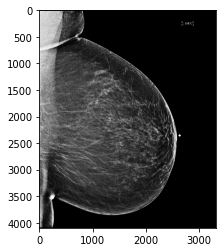

In [37]:
#Visualize a few cleaned images, and compare them with the image before cleaning.
patient_id_example_1 = '10289'
image_id_example_1 = '1616844775'
im1 = pydicom.dcmread('/kaggle/input/rsna-breast-cancer-detection/train_images/' 
                      + patient_id_example_1 + '/' + image_id_example_1 + '.dcm')
plt.imshow(im1.pixel_array, cmap='gray')

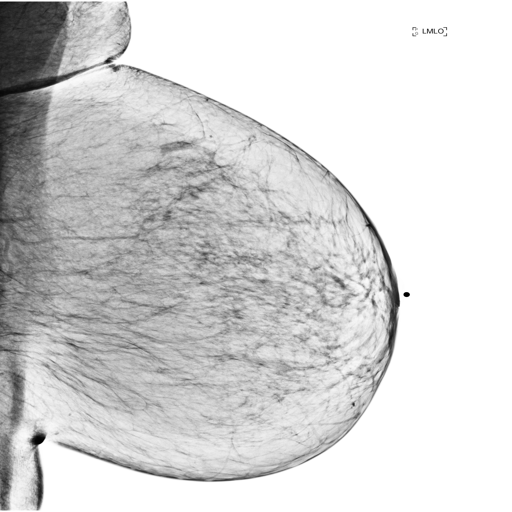

In [38]:
img_dict[patient_id_example_1 + '/' + image_id_example_1]

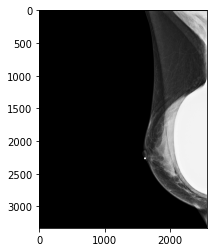

In [39]:
patient_id_example_2 = '22528'
image_id_example_2 = '1265735355'
im1 = pydicom.dcmread('/kaggle/input/rsna-breast-cancer-detection/train_images/' 
                      + patient_id_example_2 + '/' + image_id_example_2 + '.dcm')
plt.imshow(im1.pixel_array, cmap='gray')

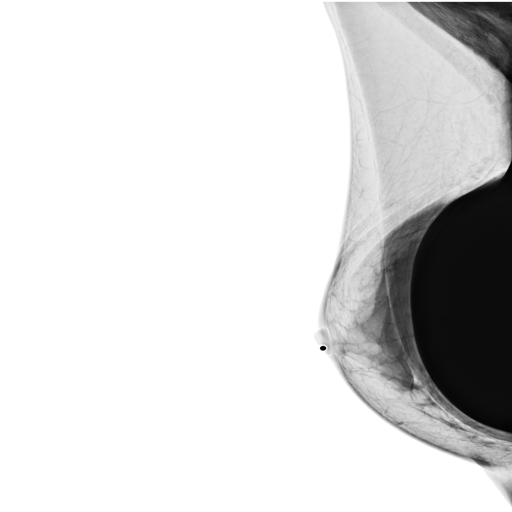

In [40]:
img_dict[patient_id_example_2 + '/' + image_id_example_2]

In [47]:
#Add cleaned-up images as a column to the dataframe train_cleaned_final.
for i in tqdm(range(train_cleaned_final.shape[0])):
    patient_id = train_cleaned_final['patient_id'][i]
    image_id = train_cleaned_final['image_id'][i]
    train_cleaned_final['cleaned_image'] = img_dict[patient_id + '/' + image_id]

  0%|          | 0/23634 [00:00<?, ?it/s]

In [50]:
#Show the first few rows of the final version of train_cleaned_final:
train_cleaned_final.head(3)

,site_id,patient_id,image_id,age,machine_id,laterality_L,laterality_R,view_CC,view_MLO,cancer_0,...,BIRADS_2.0,implant_0,implant_1,density_A,density_B,density_C,density_D,difficult_negative_case_False,difficult_negative_case_True,cleaned_image
0,1,10038,1967300488,60.0,216,1,0,0,1,1,...,0,1,0,0,0,1,0,1,0,<PIL.Image.Image image mode=L size=512x512 at ...
1,1,10038,2142944869,60.0,216,1,0,1,0,1,...,0,1,0,0,0,1,0,1,0,<PIL.Image.Image image mode=L size=512x512 at ...
2,1,10038,850559196,60.0,216,0,1,0,1,1,...,0,1,0,0,0,1,0,1,0,<PIL.Image.Image image mode=L size=512x512 at ...
